In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from wordcloud import WordCloud
from googletrans import Translator
import asyncio
from deep_translator import GoogleTranslator
from langchain_ollama import ChatOllama
from langchain_core.prompts import PromptTemplate
from pydantic import BaseModel, Field

# Classification view

In [14]:
df = pd.read_csv('../data/classification/outputs/classifications.csv')

In [9]:
df.head()

,nome,sentimento,frase
0,Vinícius Fontes de Andrade,1,O Ararabots me proporcionou experiências e mel...
1,Lucas Santana Escobar,1,"Além disto, formou laços de amizade duradouros..."
2,Matheus Kazumi Silva Miyashiro,1,"Do ponto de vista técnico, pude aplicar e apro..."
3,Guilherme Brugeff Teles,1,Me ajudou a desenvolver minha capacidade de in...
4,João Valente,0,A participação no AraraBots ainda não teve um ...


In [15]:
data = df['sentimento'].copy()
data = data.to_numpy()
data

array([1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1])

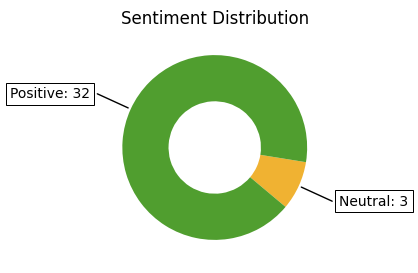

In [16]:
label_map = {-1: 'Negative', 0: 'Neutral', 1: 'Positive'}
color_map = {
    -1: '#971B2F',  # vermelho forte
     0: '#F0B232',  # cinza-azulado neutro
     1: '#509E2F'   # verde moderado
}


counts = df['sentimento'].value_counts().sort_index()
data = counts.values
labels = [label_map[i] for i in counts.index]
colors = [color_map[i] for i in counts.index]

fig, ax = plt.subplots(figsize=(6, 3), subplot_kw=dict(aspect="equal"))

wedges, texts = ax.pie(data, colors=colors, wedgeprops=dict(width=0.5), startangle=-40)

bbox_props = dict(boxstyle="square,pad=0.3", fc="w", ec="k", lw=0.72)
kw = dict(arrowprops=dict(arrowstyle="-"),
          bbox=bbox_props, zorder=0, va="center")

for i, p in enumerate(wedges):
    ang = (p.theta2 - p.theta1)/2. + p.theta1
    y = np.sin(np.deg2rad(ang))
    x = np.cos(np.deg2rad(ang))
    ha = "right" if x < 0 else "left"
    connectionstyle = f"angle,angleA=0,angleB={ang}"
    kw["arrowprops"].update({"connectionstyle": connectionstyle})
    ax.annotate(f"{labels[i]}: {data[i]}", xy=(x, y), xytext=(1.35*np.sign(x), 1.4*y),
                horizontalalignment=ha, **kw)

ax.set_title("Sentiment Distribution")
plt.savefig("sentiment_distribution.png")
plt.show()


# Extract View

In [3]:
df_classes = pd.read_csv('../data/extraction/outputs/classes_count.csv')

In [ ]:
df_classes.head()

classe    AraraBots
count             4
Name: 11, dtype: object

In [10]:
class Response(BaseModel):
    classe: str = Field(description="Classe traduzida em inglês")

model = ChatOllama(model="phi4", format="json", temperature=0.5)

template = PromptTemplate.from_template(
    """
    Você é um tradutor especializado em inglês. Sua tarefa é traduzir a classe fornecida do português para o inglês.
    
    classe: saída em inglês, sem explicações adicionais.

    Retorne no formato JSON:
    {{
        "classe": "classe traduzida em inglês"
    }}

    Classe: {texto}
    
"""
)

llm = ChatOllama(model="phi4", format="json", temperature=0.1)
structured_llm = llm.with_structured_output(Response)
chain = template | structured_llm

def traduzir_chat_ollama(texto):
    return chain.invoke({"texto": texto}).classe

translated = []

for texto in df_classes['classe']:
    try:
        if texto == "AraraBots": 
            translated.append("AraraBots")
            continue
        traducao = traduzir_chat_ollama(texto)
        translated.append(traducao)
    except Exception as e:
        print(f"Erro: {texto} - {e}")
        translated.append(texto)

df_classes['classe_en'] = translated
df_classes['classe_en']


0                   leadership
1                 pro activity
2                   innovation
3                 colaboration
4                   resilience
5                  electronics
6                  programming
7      artificial intelligence
8                  engineering
9                     teamwork
10             junior engineer
11                   AraraBots
12                      design
13             problem solving
14                    teamwork
15                     leading
16                    robotics
17    object-oriented paradigm
18                  clean code
19          clean architecture
20       theoretical knowledge
21                competitions
22          project management
Name: classe_en, dtype: object

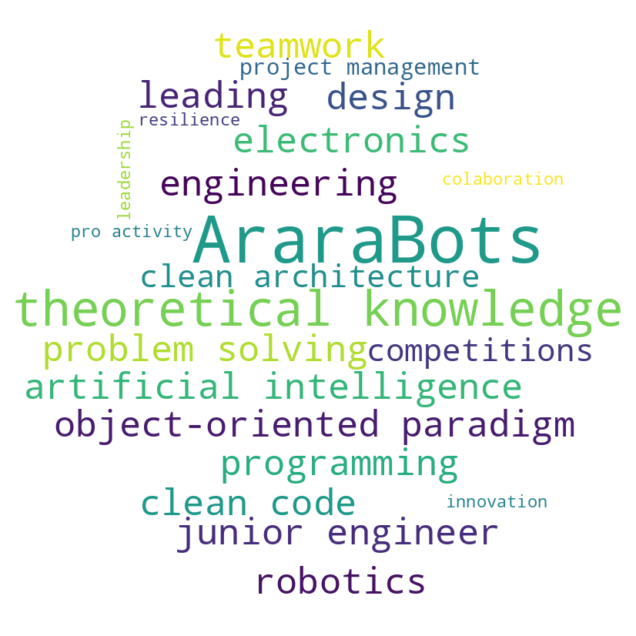

In [11]:
df = df_classes

# Dicionário de frequências
frequencies = df.set_index('classe_en')['count'].to_dict()

# Máscara circular
x, y = np.ogrid[:800, :800]
mask = (x - 400) ** 2 + (y - 400) ** 2 > 400 ** 2
mask = 255 * mask.astype(int)

# Altere repeat=True para repeat=False
wc = WordCloud(background_color="white",
               repeat=False, # Alteração aqui
               mask=mask,
               colormap='viridis')

wc.generate_from_frequencies(frequencies)

# Exiba e salve a imagem
plt.figure(figsize=(8, 8))
plt.axis("off")
plt.imshow(wc, interpolation="bilinear")
plt.savefig('wordcloud_circular_no_repeat.png')
plt.show()